## Bucket renormalization

This notebook reproduces some results from [this paper](https://arxiv.org/abs/1803.05104) on bucket renormalization. See paper for details

Also it demonstrates how to use InferLO helpers for loading UAI datasets and for caching experiment results.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from time import time
from networkx import grid_graph

import inferlo
from inferlo import testing
from inferlo.datasets import DatasetLoader
from inferlo.interop import LibDaiInterop
import inferlo.generic.inference as inf

loader = DatasetLoader()
libdai = LibDaiInterop()
assert libdai.is_libdai_ready()
exp_runner = inferlo.testing.ExperimentRunner()    

### 1. Ising model on grid

Built random Ising model on 15x15 grid, with varying interaction strength. Observed how accuracy of log partition function depends on interaction strength. 

Ran for Mini-Bucket elimination, Global-Buclet elimination. Compared with Belief Propagation, Mean Field, Mini-Bucket Elimination, Weighted Mini-Bucket Elimination. Used Bucket Elimination for getting exact answer.

Corresponds to Fig. 3(b) in the paper.

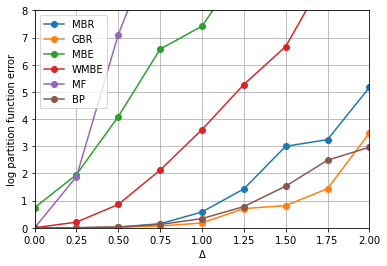

In [2]:
def ising_grid_delta_v2(grid_size=5, delta=1.0, seed=0, ibound=10):
    graph = grid_graph(dim=(grid_size, grid_size))
    model = testing.ising_model_on_graph(graph, field_range=0.1, interaction_range=delta, seed=seed) 
    true_log_pf = inf.bucket_elimination(model, elimination_order_method="not_random")
    get_error = lambda x: np.abs(x - true_log_pf) * np.log(10)
    return {
        "MBR" : get_error(inf.bucket_renormalization(model, max_iter=0)),
        "GBR" : get_error(inf.bucket_renormalization(model, max_iter=1)),
        "MBE" : get_error(inf.mini_bucket_elimination(model, ibound=ibound)),
        "WMBE" : get_error(inf.weighted_mini_bucket_elimination(model, ibound=ibound)),
        "MF" : get_error(inf.mean_field(model)),
        "BP" : get_error(libdai.infer(model, 'BP').log_pf),
    }

delta_range = np.linspace(0, 2, 9)
repeats = 3
for delta in delta_range:
    for seed in range(repeats):
        exp_runner.run_experiment(ising_grid_delta_v2, {'grid_size': 15, 'delta':delta, 'seed':seed})

results = exp_runner.get_results('ising_grid_delta_v2', filter_params={'grid_size': 15})
algos = ["MBR", "GBR", "MBE", "WMBE", "MF", "BP"]

for algo in algos:
    avg_errors = []
    for delta in delta_range:
        errors = [r['result'][algo] for r in results if r['params']['delta'] == delta]
        avg_error = np.mean(errors) / (np.log(10)**2)
        avg_errors.append(avg_error) 
    plt.plot(delta_range, avg_errors, label=algo, marker='o')

plt.xlabel('Δ')
plt.ylabel('log partition function error')
plt.grid()
plt.legend()
plt.xlim([0, 2])
plt.ylim([0, 8])
plt.show()

### 2. Promedus dataset

Corresponds to Fig. 3(f) in the paper.

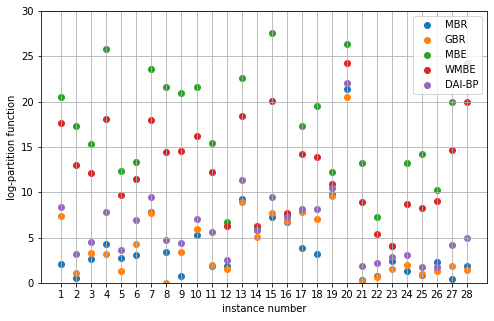

In [3]:
def infer_uai_dataset(dataset_name='', algo=''):
    model = loader.load_uai_dataset(dataset_name).model
    if algo == 'MBR':
        return inf.bucket_renormalization(model, max_iter=0)
    elif algo == 'GBR':
        return inf.bucket_renormalization(model, max_iter=1)
    elif algo == 'MBE':
        return inf.mini_bucket_elimination(model, ibound=10)
    elif algo == 'WMBE':
        return inf.weighted_mini_bucket_elimination(model, ibound=10)
    elif algo == 'BP':
        return inf.belief_propagation(model).log_pf
    elif algo == 'IJGP':
        return inf.iterative_join_graph_propagation(model, ibound=10)
    elif algo[:4] == 'DAI-':
        return libdai.infer(model, algo[4:]).log_pf
    else:
        raise ValueError(algo)
   
algos = ['MBR', 'GBR', 'MBE', 'WMBE', 'DAI-BP']
dataset_id_range = np.array(range(11, 39)) 
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1)

for algo in algos:
    errors = []
    for dataset_id in dataset_id_range:
        dataset_name = 'Promedus_%d.uai' % dataset_id
        true_log_pf = loader.load_uai_dataset(dataset_name).true_log_pf
        result = exp_runner.run_experiment(infer_uai_dataset, {'dataset_name': dataset_name, 'algo': algo})
        error_log10 = np.abs(result['result'] - true_log_pf) / np.log(10)
        errors.append(error_log10)
    ax.scatter(dataset_id_range - 10, errors, label=algo)
    
ax.set_xlabel('instance number')    
ax.set_ylabel('log-partition function')    
ax.set_xticks(dataset_id_range - 10)
ax.set_ylim([0, 30])
ax.grid()
ax.legend()
plt.show()    